# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


[44592 27460  1674 19347 34235 40448 10782]
[27382  4352  7605 39373 17126 25377 14668]
[ 5825 11156 30287 16472 47009 30312 18727]
[ 2011 23218 30332 16273 31013 11498 36633]
[42643 25099 11506 11402 37960 37463 42938]
[ 4135 42152 13392 47221 48693 29006   305]
[29547 46193 37940 43250 15962  1989 31906]
[33469 13284 36278 27327 38597 32640 32638]
[  501 38733  7231 13131 45697 18118    62]
[17109 28544 38018  7421 29938 25409  1235]


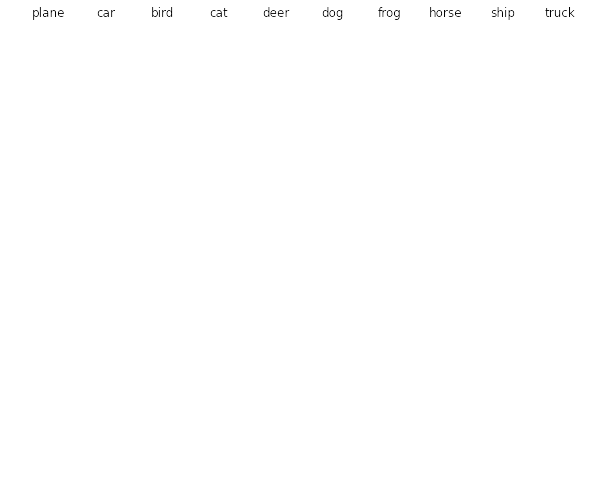

In [18]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    print idxs
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        #plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
print y_train.shape
print X_train.shape

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

(5000,)
(5000, 32, 32, 3)


In [188]:
# Reshape the image data into rows
print X_train.shape[0]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

x = np.zeros((2, 3))
print x
x = [[1, 2, 3]]
y = [[1, 2, 3], [4, 5, 6],[8, 9, 10]]
print x
print y

z = np.sum(np.power(np.subtract(x, y), 2), axis = 1)
print z

print y[0]
print np.subtract(x, y[0])
z1 = np.sum(np.power(np.subtract(x, y[0]), 2))
z2 = np.sum(np.power(np.subtract(x, y[1]), 2))
z3 = np.sum(np.power(np.subtract(x, y[2]), 2))
print z1 + z2 + z3

yy = [1, 3, 3, 4, 9]
print yy
print np.bincount(yy)

x = [[1, 2, 3], [4, 5, 6]]
y = [[1, 2, 3], [4, 5, 6],[8, 9, 10]]
print x
print y

xx = np.sum(np.power(x, 2), axis = 1)
yy = np.sum(np.power(y, 2), axis = 1)

xy = np.dot(x, np.transpose(y)) * (-2)
print xx
print yy
print xy

print (xy + np.reshape(xx, (2, 1)))
print (xy + np.reshape(xx, (2, 1)) + yy)

y = [[1, 2, 3], [4, 5, 6],[8, 9, 10], [11, 12, 13]]
sy = np.array_split(y, 2, axis = 0)
print sy[0][1]
print sy[1]

print np.concatenate((x, y), axis = 0)[1:3]

5000
(5000, 3072) (500, 3072)
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
[[1, 2, 3]]
[[1, 2, 3], [4, 5, 6], [8, 9, 10]]
[  0  27 147]
[1, 2, 3]
[[0 0 0]]
174
[1, 3, 3, 4, 9]
[0 1 0 2 1 0 0 0 0 1]
[[1, 2, 3], [4, 5, 6]]
[[1, 2, 3], [4, 5, 6], [8, 9, 10]]
[14 77]
[ 14  77 245]
[[ -28  -64 -112]
 [ -64 -154 -274]]
[[ -14  -50  -98]
 [  13  -77 -197]]
[[  0  27 147]
 [ 27   0  48]]
[4 5 6]
[[ 8  9 10]
 [11 12 13]]
[[4 5 6]
 [1 2 3]]


In [232]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
print type(y_train)
print y_train.shape

<type 'numpy.ndarray'>
(5000,)


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [80]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

two loop 

(500, 5000)


[autoreload of cs231n.classifiers.k_nearest_neighbor failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "cs231n/classifiers/k_nearest_neighbor.py", line 75
    dists[i, j] = np.sum(np.power(np.subtract(X[i], self.X_train[j])), 2))
                                                                         ^
SyntaxError: invalid syntax
]


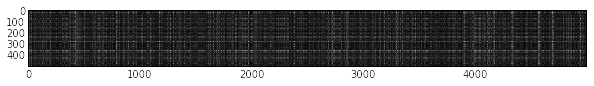

[ 27775852.  16326740.  41351316.  28629392.  37141466.  27793424.
  42858649.  32606852.  41012193.]
[  8593810.   8748621.   9036093.   9273096.   9852850.   9961967.
   9985194.  10000286.  10003513.]
[8 8 8 0 0 1 8 8 1]


In [95]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

print dists[1, 1:10]
tmp = np.argsort(dists, axis = 1)

print dists[1, tmp[1, 1:10]]
print y_train[tmp[1, 1:10]]

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [145]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)


Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [144]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [150]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

one loop 

Difference was: 0.000000
Good! The distance matrices are the same


In [176]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [177]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

two loop 

Two loop version took 109.404811 seconds
one loop 

One loop version took 120.838242 seconds
No loop version took 1.310949 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [240]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

print len(X_train_folds)
print len(y_train_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    accuracy = [0, 0, 0, 0, 0]
    print accuracy
    for i in xrange(num_folds):
        x_test = X_train_folds[i]
        y_test = y_train_folds[i]
        x_test = np.reshape(x_test, (x_test.shape[0], -1))
        
        x_train_tmp = X_train_folds[0:i] + X_train_folds[i+1:num_folds]
        y_train_tmp = y_train_folds[0:i] + y_train_folds[i+1: num_folds]
        x_train_tmp = np.reshape(x_train_tmp, (x_train_tmp[0].shape[0] * len(x_train_tmp), -1))
        y_train_tmp = np.reshape(y_train_tmp, (4000))
        
        # train
        classifier_tmp = KNearestNeighbor()
        
        classifier_tmp.train(x_train_tmp, y_train_tmp)
        # predict

        dists_two = classifier_tmp.compute_distances_no_loops(x_test)
        y_test_pred = classifier_tmp.predict_labels(dists_two, k)
        # accuracy
        num_correct = np.sum(y_test_pred == y_test)
        accuracy[i] = (float(num_correct) / 1000)
        #print accuracy
    k_to_accuracies[k] = accuracy
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

5
5
[0, 0, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
0
[0.263, 0, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
1
[0.263, 0.257, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
2
[0.263, 0.257, 0.264, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
3
[0.263, 0.257, 0.264, 0.278, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
4
[0.263, 0.257, 0.264, 0.278, 0.266]
[0, 0, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
0
[0.239, 0, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
1
[0.239, 0.249, 0, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
2
[0.239, 0.249, 0.24, 0, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
3
[0.239, 0.249, 0.24, 0.266, 0]
<type 'numpy.ndarray'>
(4000, 3072)
<type 'numpy.ndarray'>
(4000,)
4
[0.239, 0.249, 0.24, 0.266, 0.25

/usr/lib/pymodules/python2.7/matplotlib/collections.py:446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


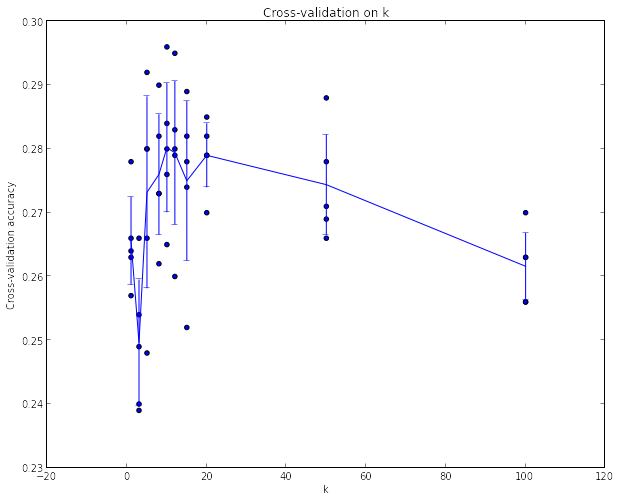

In [241]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [242]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 12

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

one loop 

Got 0 / 500 correct => accuracy: 0.000000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
